# Cooking ingredients recommendation
## Association Rule Mining
* This notebook builds a recommendation system for cooking ingredients using Association Rule Mining.  
* Contents
1. Load data
2. Learn rules from training set 
3. Query the rules
4. Build a recommender from learned rules 
5. Hyperparameter tuning
6. Create final model
7. Evaluation

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [1]:
# Python standard libraries
import ast 
import csv
import os
import pickle
import random
import re
import statistics
import time
from collections import Counter 
from itertools import combinations

# Third party imports 
import h5py
import ijson
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from efficient_apriori import apriori
from matplotlib import style
plt.style.use('ggplot')

# custom functions
import functions as fn

# Association rule mining

* Association rule mining is a tool used in <b>market basket analysis</b> that looks for combinations of <b>items that are frequently purchased together.</b>  
* It finds rules of the form X => Y, which represents "X implies Y"  
    * ex) The rule {onions, potatoes} => {burger} found in the sales data would indicate that if a customer buys both onions and potatoes, then they are also likely to buy hamburger meat.  

* In this project, I used association rule mining to detect <b>ingredients that are frequently cooked together.</b>  
* For example, the rule <b>{chicken, korean} => {seasame oil}</b> would imply that if a recipe involves chicken and korean cuisine, then it is likely to also involve seasame oil as its ingredient. 
* Used Apriori algorithm to learn the rules.

# The apriori algorithm

* The apriori algorithm learns all rules of form X => Y where
    * X, Y are collections of ingredients, called itemset.
    * X, Y are itemsets that occur frequently enough, as measured by <b>support</b>. 
        * support of itemset X = {ingredient_1, ... ,ingredient_k}: Proportion of documents that contain itemse X 
    * The strength of the implication X => Y is strong, as measured by <b>confidence</b>    
        * confidence of rule X => Y : Proportion of transactions that contain X which also contain Y.  
        * $confidence(X => Y) = \frac{support(XUY)}{support(X)}$  
        * $confidence(X => Y)$ estimates P( Document contains Y | Document contains X)

* Apriori algorithm requires to parameters: <b>min_support</b> and <b>min_confidence</b> 
* In this section, I chose a minimum support of 0.001 and minimum confidence of 0.3.  
* In a later section, I perform hyperparamter tuning during which I select a good pair of (min support, min confidence). 

# 1. Load data

In [2]:
# load balanced training data
df_balanced = pd.read_csv('data/ingredient_recommendation/balanced_training.csv')

# Convert to correct format 
# list of lists
train_balanced = [ast.literal_eval(df_balanced.document[idx]) for idx in range(df_balanced.shape[0])]
# change data format to list of tuples for apriori algorithm 
train_balanced = [tuple(item) for item in train_balanced]

In [3]:
# load train, cv, test data index
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
cv_idx = list(f.get("cv_idx"))
test_idx = list(f.get("test_idx"))
f.close()

# load data CV and test data
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = np.unique(df.cuisine)

# Convert to correct format (list of lists)
documents = [ast.literal_eval(df.document[idx]) for idx in range(df.shape[0])]

# change data format to list of tuples for apriori algorithm 
documents = [tuple(item) for item in documents]

# CV  
cv_doc = [documents[i] for i in cv_idx]

In [6]:
# get the list of all ingredients
ingredients_total = [item for ing_tuple in documents for item in ing_tuple]

# count occurrence of ingredients
ing_count = Counter(ingredients_total)

# sort ingredients in order of decreasing frequency 
ing_by_count = [k for k, v in sorted(ing_count.items(), key = lambda item:item[1])]
ing_by_count.reverse()

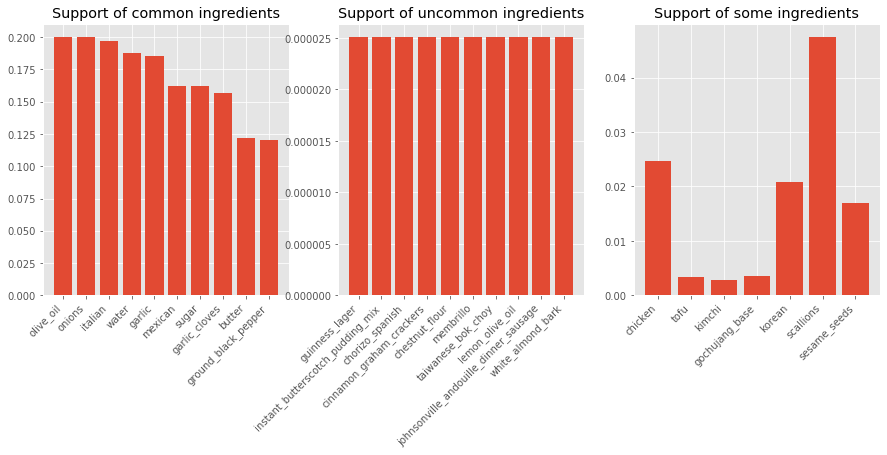

In [20]:
#plot the support of 10 most frequently and rarely occurring ingredients 
fig, ax = plt.subplots(ncols = 3, figsize = (15,5))

# 10 most frequently occuring ingredients 
ax[0].bar(ing_by_count[:10], [ing_count[item]/len(documents) for item in ing_by_count[:10]])
ax[0].set_xticks(list(range(10)), ing_by_count[:10])
ax[0].set_title('Support of common ingredients')

# 10 most infrequently occuring ingredients
ax[1].bar(ing_by_count[-10:], [ing_count[item]/len(documents) for item in ing_by_count[-10:]])
ax[1].set_xticks(list(range(10)), ing_by_count[-10:])
ax[1].set_title('Support of uncommon ingredients')

# support of some ingredients of interest
my_ingredients = ['chicken','tofu','kimchi', 'gochujang_base', 'korean', 'scallions', 'sesame_seeds']
ax[2].bar(my_ingredients, [ing_count[item]/len(documents) for item in my_ingredients])
ax[2].set_xticks(list(range(len(my_ingredients))), my_ingredients)
ax[2].set_title('Support of some ingredients')

# rotate labels
plt.setp(ax[0].get_xticklabels() + ax[1].get_xticklabels() + ax[2].get_xticklabels(), rotation=45, ha='right')
plt.show()

# 2. Learn rules from training set

In [5]:
# LEARNING THE RULES USING ONLY THE TRAINING SET 
itemsets, rules = apriori(train_doc, min_support=0.001, min_confidence=0.3)
with open("models/association_rule_mining/training_rules.txt", "wb") as fp:
    pickle.dump(rules, fp)

# 3. Query the rules 

In [6]:
# load the learned rules
with open("models/association_rule_mining/training_rules.txt", "rb") as fp:
    rules = pickle.load(fp)
    
print('number of rules learned: ', len(rules))

number of rules learned:  38661


In [7]:
def get_rules(rules, query):
    # Find all rules of the form "query" => ?

    # query must have the format ('ingredient1', ) or ('ingredient1','ingredient2', ... ,)
    # note that some rules will have multiple items in the right hand side. For simplicity, lets just
    # use rules that return one value 
    query_rules = [item for item in rules if set(item.lhs) == set(query)]

    # sorted ccording to decreasing lift values 
    query_rules = sorted(query_rules, key=lambda rule: rule.lift, reverse = True)
    return query_rules   

In [10]:
query = ('gochujang_base',)
query_rules = get_rules(rules, query)
for item in query_rules:
    print(item)

{gochujang_base} -> {korean, onions} (conf: 0.343, supp: 0.001, lift: 63.166, conv: 1.513)
{gochujang_base} -> {green_onions, korean} (conf: 0.380, supp: 0.001, lift: 52.065, conv: 1.600)
{gochujang_base} -> {korean, soy_sauce} (conf: 0.583, supp: 0.002, lift: 50.594, conv: 2.372)
{gochujang_base} -> {korean, sesame_oil} (conf: 0.537, supp: 0.002, lift: 50.173, conv: 2.137)
{gochujang_base} -> {korean, sesame_oil, soy_sauce} (conf: 0.380, supp: 0.001, lift: 50.091, conv: 1.600)
{gochujang_base} -> {korean, sugar} (conf: 0.333, supp: 0.001, lift: 45.942, conv: 1.489)
{gochujang_base} -> {garlic, korean} (conf: 0.361, supp: 0.001, lift: 45.287, conv: 1.553)
{gochujang_base} -> {korean} (conf: 0.963, supp: 0.004, lift: 45.059, conv: 26.423)
{gochujang_base} -> {sesame_oil, soy_sauce} (conf: 0.398, supp: 0.002, lift: 13.926, conv: 1.614)
{gochujang_base} -> {sesame_oil} (conf: 0.556, supp: 0.002, lift: 12.404, conv: 2.149)
{gochujang_base} -> {soy_sauce} (conf: 0.620, supp: 0.002, lift: 7.

In [11]:
query = ('chicken','soy_sauce')
query_rules = get_rules(rules, query)
for item in query_rules:
    print(item)

{chicken, soy_sauce} -> {chinese} (conf: 0.402, supp: 0.001, lift: 6.015, conv: 1.561)
{chicken, soy_sauce} -> {garlic} (conf: 0.368, supp: 0.001, lift: 1.999, conv: 1.291)


# 4. Build a recommendation system

* Recommender input: list of existing ingredients and n (number of ingredients to recommend)  
* Repeat the followinig until at least "n" ingredients are recommended:
     * Look for largest itemset among existing ingredients with high enough support.  
     * Find rules X => Y with the found set as the LHS. Report starting with rules with highest lift. 
     * Recommend ingredients in Y only if they do not exist in current list of ingredients 
* Recall lift of rule X => Y:
    * Lift(X=>Y) = $\frac{support(X \cup Y)}{support(X) support(Y)}$ 
    * Ratio of obseerved support to that expected if X and Y were independent 
    * If lift(X=>Y) == 1, then X and Y are independent. 
    * If lift(X=>Y) > 1, then X and Y are depependent on one another.
    * If lift(X=>Y) < 1, then X and Y are substitutes. 


In [23]:
def get_rules(rules, query, lift_threshold = 1):
    # Find all implication rules of the form "query" => RHS
    # such that (i) RHS is a single ingredient and 
    #           (ii) lift value is greater than lift_threshold

    # "query" format ('ingredient1', ) or ('ingredient1','ingredient2', ... ,)
    query = tuple(query)    
    
    # get all rules "query" => RHS satisfying the conditions above
    query_rules = [item for item in rules if set(item.lhs) == set(query) 
                   if item.lift > lift_threshold and len(item.rhs) == 1]

    # sort rules according to decreasing lift values 
    query_rules = sorted(query_rules, key=lambda rule: rule.lift, reverse = True)
    return query_rules   

def single_recommend_ARM(list_ing, list_old, cuisine, rules):   #reccommend
    # Make one round of recommendation given a list of ingredients. 
    # Note: one round of recommendation may recommend multiple ingredients. 
    # Given a list of ingredients, attempt to find the largest subset S of "n" elements such that
    # (i) S isn't a subset of list_old and
    # (ii) S exists as a left hand side element in "rules"
    # If such "n" is found, then try recommending ingredients according to "rules"
    
    """
    list_ing: current list of ingredients 
    list_old: List of ingredients (a subset of list_ing) that have previously
            been used to ask for ingredient recommentations. 
            For first round of recommendations, list_old = []
            We keep track of "list_old" so that we don't make duplicate
            recommendations.
    cuisine: (list) cuisinie names 
    rules: rules learned from apriori algorithm
    """           

    rules_lhs = {item.lhs for item in rules}
    n = len(list_ing)
    current_list = list_ing.copy()
    new_ing = []

    itemset_found = False
    
    while itemset_found == False and n > 0:
        # find all itemsets of size n
        comb = combinations(list_ing, n)

        # check if any itemset of size n satifies the conditions
        # (i) itemset isn't a subset of list_old  
        # (ii) itemset exists as a left hand side element in rules 
        for itemset in comb:
            if (set(itemset).issubset(set(list_old)) == False) and (itemset in rules_lhs):
 
                # check if the itemset leads to a new ingredient recommendation
                query_rules = get_rules(rules, itemset)
                recommendation = [item.rhs[0] for item in query_rules]
                for ing in recommendation:
                    # if there exists an ingredient that is new and is not a cuisine type
                    # then this itemset just contributed a valid recommendation
                    if (ing not in current_list) and (ing not in cuisine):
                        current_list.append(ing)
                        new_ing.append(ing)            
                        itemset_found = True

        n = n-1           
    return new_ing

def multiple_recommendations_ARM(list_ing, cuisine, rules, n): 
    # Make multiple rounds of recommendations by calling the function "single_recommend_ARM" 
    # until "n" or more ingredients have been recommended
    # or until no more ingredients can be recommended by the function "single_recommend_ARM"
    
    """
    list_ing: (list) of ingredients 
    cuisine: (list) cuisinie names 
    rules: rules learned from apriori algorithm
    n: (int) number of ingredients to recommend
    """     

    initial_ing = list_ing.copy()
    initial_length = len(initial_ing)
    current_ing = list_ing.copy()
    list_old = []
    while len(current_ing) <= initial_length + n:
        new_ing = single_recommend_ARM(current_ing, list_old, cuisine, rules)
        list_old = current_ing.copy()
        current_ing += new_ing
        if new_ing == []:
            break    
    recommended_ing = [item for item in current_ing if item not in initial_ing]
            
    return recommended_ing

def recommend_ARM(rules, existing_ing, cuisine, n):
    # Recommend ingredients using rules learned from Association Rule Mining
    
    """
    rules: rules learned from Association Rule Mining
    existing_ing: (list of lists) Each item is a list of existing ingredients for a particular recipe 
    cuisine: (list) of cuisine names
    n: (int) number of ingredients to recommend
    """
    
    recommend_ing = []

    for idx, doc in enumerate(existing_ing):

        # recommend ingredients
        rec = multiple_recommendations_ARM(doc, cuisine, rules , n)
        recommend_ing.append(rec)
        
    return recommend_ing


In [6]:
# load the learned rules
with open("models/association_rule_mining/training_rules.txt", "rb") as fp:
    rules = pickle.load(fp)
    
print('number of rules learned: ', len(rules))

number of rules learned:  38661


In [7]:
# ask the recommender for ingredients!
list_ing = ['pork', 'korean']
multiple_recommendations_ARM(list_ing, cuisine, rules, 10)

['soy_sauce',
 'garlic',
 'onions',
 'water',
 'sesame_oil',
 'green_onions',
 'sugar',
 'sesame_seeds',
 'corn_starch',
 'ginger',
 'oil']

# 5. Do hyperparameter tuning   

* Apriori algorithm involves two parameters: <b>min_support</b> and <b>min_confidence</b>
    * Reasonable range of min_support: 0.001 - 0.1 
    * Reasonable range of min_confidence: 0.1 - 0.5 
* While we could run the Apriori algorithm for various pairs of min_support and min_confidence values, this would take a lot of time. Time complexity of Apriori algorithm is $O(2^n)$, where $n$ is the number of ingredients.  
* Instead, note that the <b>rules learned for min_support = 0.001 and min_confidence = 0.1</b> contains all the rules for higher values of min_support and  min_confidence.  
* I found all the rules with parameters min_support = 0.001 and min_confidence = 0.1.  
* I then sampled 100 different pairs of min_support and min_confidence values.  
    * min_support values are sampled from 0.001 - 0.1
    * min_confidence values are sampled from 0.1 - 0.5 
    * Each value is sampled in the log-scale, so that values close to the lower end (0.001 and 0.1) are sampled more.  
* For each sampled min_support and min_confidence value, I filtered the rules accordingly. 
* I then compared the performance of the recommenders based on the rules using median F score.

In [41]:
# for various pairs of support and confidence values, get performance on CV set
precision_mean = {}
recall_mean = {}
Fscores_mean = {}

precision_median = {}
recall_median = {}
Fscores_median = {}

# get existing ingredients and the remaining ingredients to be predicted
existing_ing, missing_ing = sample_ingredients(cv_doc, 5)

# sample 100 points in log scale
for i in range(100):
    support_log = np.random.uniform(np.log10(0.001), np.log10(0.1), 1)[0]
    supp = round(10**support_log,4)

    confidence_log = np.random.uniform(np.log10(0.1), np.log10(0.5), 1)[0]
    conf = round(10**confidence_log,4)

    # get rules 
    sub_rules = [item for item in rules if item.support > supp and item.confidence > conf]

    # predict remaining ingredients
    rec_ing = recommend_ARM(sub_rules, existing_ing, cuisine, 6)

    # compute avergae scores
    scores = [compute_scores(rec_ing[i], missing_ing[i]) for i in range(len(missing_ing))]

    precisions = [item[0] for item in scores] 
    recalls = [item[1] for item in scores]
    Fscores = [item[2] for item in scores]
    
    precision_median[(supp, conf)] = [statistics.median(precisions)]
    recall_median[(supp, conf)] = [statistics.median(recalls)]
    Fscores_median[(supp, conf)] = [statistics.median(Fscores)]


In [42]:
# save F-score median
with open("models/association_rule_mining/balanced_hyperparameter_Fscores.txt", "wb") as fp:
    pickle.dump(Fscores_median, fp)

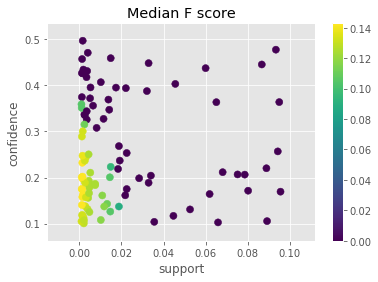

In [43]:
# plot the median F-scores for various confidence and support values
sample_supp = []
sample_conf = []
sample_Fmedian = []
for key in Fscores_median.keys():
    sample_supp.append(key[0])
    sample_conf.append(key[1])
    sample_Fmedian.append(Fscores_median[key][0])
    
plt.scatter(sample_supp, sample_conf, c = sample_Fmedian, s = 50)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Median F score')
plt.colorbar()
plt.show()

From the above graph, it looks like the model performs best when the support value is very small (close to 0.001), and when the confidence is around 0.2.
We'll select the model with min_support = 0.001 and min_confidence = 0.2

# 6. Create model with selected hyperparameters

In [4]:
# Learn rules from training set 
itemsets, rules = apriori(train_balanced, min_support=0.001, min_confidence=0.2)
with open("models/association_rule_mining/balanced_training_rules_s001_c2.txt", "wb") as fp:
    pickle.dump(rules, fp)

In [22]:
print('number of rules learned: ', len(rules))

number of rules learned:  67267


# 7. Evaluation


## 7 (a) evaluation on train set

In [76]:
# get existing ingredients and the remaining ingredients to be predicted
existing_ing, missing_ing = sample_ingredients(train_doc, 5)

# predict remaining ingredients
rec_ing = recommend_ARM(rules, existing_ing, cuisine, 6)

In [78]:
scores = [compute_scores(rec_ing[i], missing_ing[i]) for i in range(len(missing_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

# save scores
scores = {}
scores['precision'] = precisions
scores['recall'] = recalls
scores['Fscores'] = Fscores

with open("models/association_rule_mining/training_scores.txt", "wb") as fp:
    pickle.dump(scores, fp)

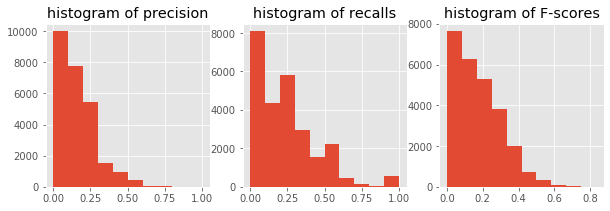

Median precision on training set:  0.125
Median recall on training set:  0.2
Median F-score on training set:  0.15384615384615383
Mean precision on training set:  0.14671094224087255
Mean recall on training set:  0.22609225292776863
Mean F-score on training set:  0.1623420689786229


In [16]:
with open("models/association_rule_mining/training_scores.txt", "rb") as fp:
    scores = pickle.load(fp)

train_precision = scores['precision']
train_recall = scores['recall']
train_F = scores['Fscores']
    
fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(train_precision)
ax[0].set_title('histogram of precision')

ax[1].hist(train_recall)
ax[1].set_title('histogram of recalls')

ax[2].hist(train_F)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Median precision on training set: ", statistics.median(train_precision) )
print("Median recall on training set: ", statistics.median(train_recall) )
print("Median F-score on training set: ", statistics.median(train_F) )

print("Mean precision on training set: ", statistics.mean(train_precision) )
print("Mean recall on training set: ", statistics.mean(train_recall) )
print("Mean F-score on training set: ", statistics.mean(train_F) )

## 7 (b) evaluation on CV set

In [34]:
# get existing ingredients and the remaining ingredients to be predicted
existing_ing, missing_ing = sample_ingredients(cv_doc, 5)

# predict remaining ingredients
rec_ing = recommend_ARM(rules, existing_ing, cuisine, 6)

In [35]:
scores = [compute_scores(rec_ing[i], missing_ing[i]) for i in range(len(missing_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

# save scores
scores = {}
scores['precision'] = precisions
scores['recall'] = recalls
scores['Fscores'] = Fscores

with open("models/association_rule_mining/balanced_cv_scores.txt", "wb") as fp:
    pickle.dump(scores, fp)

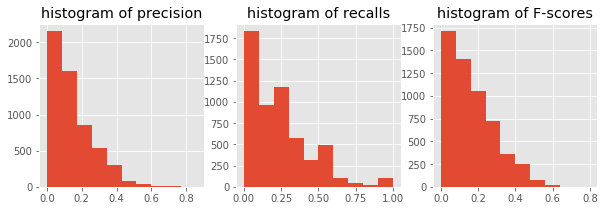

Median precision on cross validation set:  0.11764705882352941
Median recall on cross validation set:  0.2
Median F-score on cross validation set:  0.14285714285714285
Mean precision on cross validation set:  0.1382546067322209
Mean recall on cross validation set:  0.21999675829835352
Mean F-score on cross validation set:  0.15534614970835392


In [36]:
fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Median precision on cross validation set: ", statistics.median(precisions) )
print("Median recall on cross validation set: ", statistics.median(recalls) )
print("Median F-score on cross validation set: ", statistics.median(Fscores) )

print("Mean precision on cross validation set: ", statistics.mean(precisions) )
print("Mean recall on cross validation set: ", statistics.mean(recalls) )
print("Mean F-score on cross validation set: ", statistics.mean(Fscores) )